In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
from tensorflow import math as tfm
#import tensorflow_probability as tfp
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
#import cartopy.crs as ccrs
import matplotlib.ticker as mticker
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle
import sklearn
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from cbrain.imports import *
from cbrain.utils import *
from cbrain.normalization import *
import h5py
from sklearn.preprocessing import OneHotEncoder
from cbrain.climate_invariant import *
import yaml
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
# Load coordinates (just pick any file from the climate model run)
coor = xr.open_dataset("/DFS-L/DATA/pritchard/tbeucler/SPCAM/sp8fbp_minus4k/sp8fbp_minus4k.cam2.h2.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();
path = '/export/nfs0home/ankitesg/CBrain_project/CBRAIN-CAM/cbrain/'
path_hyam = 'hyam_hybm.pkl'

hf = open(path+path_hyam,'rb')
hyam,hybm = pickle.load(hf)

## Data Generators

### Data Generator for RH

In [3]:
scale_dict = load_pickle('/export/nfs0home/ankitesg/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')
scale_dict['RH'] = 0.01*L_S/G, # Arbitrary 0.1 factor as specific humidity is generally below 2%

in_vars_RH = ['RH','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars_RH = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

TRAINFILE_RH = 'CI_RH_M4K_NORM_train_shuffle.nc'
NORMFILE_RH = 'CI_RH_M4K_NORM_norm.nc'
VALIDFILE_RH = 'CI_RH_M4K_NORM_valid.nc'
BASE_DIR = '/DFS-L/DATA/pritchard/ankitesg/'

In [4]:
train_gen_RH = DataGenerator(
    data_fn = f"{BASE_DIR}data/{TRAINFILE_RH}",
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = f"{BASE_DIR}data/{NORMFILE_RH}",
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

### Data Generator for TNS

In [5]:
in_vars = ['QBP','TfromNS','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

TRAINFILE_TNS = 'CI_TNS_M4K_NORM_train_shuffle.nc'
NORMFILE_TNS = 'CI_TNS_M4K_NORM_norm.nc'
VALIDFILE_TNS = 'CI_TNS_M4K_NORM_valid.nc'

In [6]:
train_gen_TNS = DataGenerator(
    data_fn = f"{BASE_DIR}data/{TRAINFILE_TNS}",
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = f"{BASE_DIR}data/{NORMFILE_TNS}",
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

### Data Generator Combined

In [7]:
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

In [8]:
## this won't be used just to show we can use it overall
TRAINFILE = 'CI_SP_M4K_train_shuffle.nc'
NORMFILE = 'CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'CI_SP_M4K_valid.nc'

In [9]:
train_gen = DataGeneratorClimInv(
    data_fn = f"{BASE_DIR}data/{TRAINFILE}",
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = f"{BASE_DIR}data/{NORMFILE}",
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
    rh_trans = True,t2tns_trans=True,
    lhflx_trans=True,
    scaling=False,
    interpolate=False
)

valid_gen = DataGeneratorClimInv(
    data_fn = f"{BASE_DIR}data/{VALIDFILE}",
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = f"{BASE_DIR}data/{NORMFILE}",
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
    rh_trans = True,t2tns_trans=True,
    lhflx_trans=True,
    scaling=False,
    interpolate=False
)


ban toh raha hai
None
ban toh raha hai
None


## Build Model

In [54]:
inp = Input(shape=(64,))
densout = Dense(128, activation='linear')(inp)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
dense_out = Dense(64, activation='linear')(densout)
model = tf.keras.models.Model(inp, dense_out)

In [55]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8320      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 128)               0   

In [56]:
model.compile(tf.keras.optimizers.Adam(), loss=mse)
path_HDF5 = '/DFS-L/DATA/pritchard/ankitesg/models/'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint(path_HDF5+'RH_TNSV2_LH.hdf5',save_best_only=True, monitor='val_loss', mode='min')

In [57]:
Nep = 10
model.fit_generator(train_gen, epochs=Nep, validation_data=valid_gen,\
              callbacks=[earlyStopping, mcp_save])

Epoch 1/20
  997/41376 [..............................] - ETA: 19:57 - loss: 933.7019

KeyboardInterrupt: 

### Model with TNS and LHFLX transformation

In [9]:
train_gen = DataGeneratorClimInv(
    data_fn = f"{BASE_DIR}data/{TRAINFILE}",
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = f"{BASE_DIR}data/{NORMFILE}",
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
    rh_trans = True,t2tns_trans=True,
    lhflx_trans=True,
    scaling=False,
    interpolate=False
)

valid_gen = DataGeneratorClimInv(
    data_fn = f"{BASE_DIR}data/{VALIDFILE}",
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = f"{BASE_DIR}data/{NORMFILE}",
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
    rh_trans = True,t2tns_trans=True,
    lhflx_trans=True,
    scaling=False,
    interpolate=False
)


ban toh raha hai
None
ban toh raha hai
None


In [10]:
train_gen[0][0]

array([[-3.1150199e-02, -2.5735410e-02, -5.7867717e-02, ...,
        -9.6184701e-02, -8.5013285e-03, -2.6119235e-06],
       [-3.0725701e-02, -2.4526425e-02, -4.3158535e-02, ...,
        -1.1248506e-01,  1.8772926e-02, -5.9310842e-06],
       [-3.0707045e-02, -2.4309644e-02, -4.8080746e-02, ...,
        -2.0640454e-01, -2.7730091e-02, -7.2621669e-06],
       ...,
       [-3.1045359e-02, -2.4920296e-02, -4.6747047e-02, ...,
        -2.3120576e-01, -1.3915333e-02,  1.0293472e-06],
       [-3.1090843e-02, -2.5133165e-02, -5.3446773e-02, ...,
        -2.3120576e-01, -4.2218819e-02, -1.1578744e-06],
       [-3.0709369e-02, -2.4279768e-02, -4.7063876e-02, ...,
        -2.3120576e-01, -6.9839531e-03, -9.0505199e-07]], dtype=float32)

In [11]:
inp = Input(shape=(64,))
densout = Dense(128, activation='linear')(inp)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
dense_out = Dense(64, activation='linear')(densout)
model = tf.keras.models.Model(inp, dense_out)

In [12]:
model.compile(tf.keras.optimizers.Adam(), loss=mse)
path_HDF5 = '/DFS-L/DATA/pritchard/ankitesg/models/'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint(path_HDF5+'RH_TNSV2_LHV2.hdf5',save_best_only=True, monitor='val_loss', mode='min')

In [13]:
with tf.device('/gpu:2'):
    Nep = 10
    model.fit_generator(train_gen, epochs=Nep, validation_data=valid_gen,\
                  callbacks=[earlyStopping, mcp_save])

Epoch 1/10
41376/41376 [==============================] - 1451s 35ms/step - loss: 440.0452 - val_loss: 399.6728
Epoch 2/10
41376/41376 [==============================] - 1451s 35ms/step - loss: 399.2769 - val_loss: 392.4239
Epoch 3/10
41376/41376 [==============================] - 1465s 35ms/step - loss: 393.5937 - val_loss: 388.5102
Epoch 4/10
41376/41376 [==============================] - 1462s 35ms/step - loss: 390.2530 - val_loss: 384.5634
Epoch 5/10
41376/41376 [==============================] - 1468s 35ms/step - loss: 388.2070 - val_loss: 385.2683
Epoch 6/10
41376/41376 [==============================] - 1476s 36ms/step - loss: 386.8442 - val_loss: 384.8619
Epoch 7/10
41376/41376 [==============================] - 1483s 36ms/step - loss: 385.7476 - val_loss: 382.8121
Epoch 8/10
41376/41376 [==============================] - 1477s 36ms/step - loss: 384.6677 - val_loss: 380.8941
Epoch 9/10
41376/41376 [==============================] - 2661s 64ms/step - loss: 383.8629 - val_loss: 3

## Model Diagonostics

In [212]:
path_HDF5 = '/DFS-L/DATA/pritchard/ankitesg/models/' # Path to NN weights
config_file = 'CI_SP_M4K_CONFIG.yml' # Configuration file
data_file = ['CI_SP_M4K_valid.nc','CI_SP_P4K_valid.nc']  # Validation/test data sets
NNarray = ['CI01_RH_TNS_LHQsat.hdf5', 'RH_TNSV2_LHV2.hdf5','RH.hdf5', 'RH_TNS.hdf5'] # NN to evaluate 
NNname = ['RH-TNS-LH','RH-TNSV2-LHV2','RH', 'RH-TNS'] # Name of NNs for plotting
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,
            'QV2RH':QV2RH,'T2TmTNS':T2TmTNS,'eliq':eliq,'eice':eice,'esat':esat,'qv':qv,'RH':RH,
           'reverseInterpLayer':reverseInterpLayer,'ScaleOp':ScaleOp}

In [213]:
# Indices of different variables
PHQ_idx = slice(0,30)
TPHYSTND_idx = slice(30,60)


In [214]:

#define default values


NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = path_HDF5+NNs
    
    rh_trans=False
    t2tns_trans=False
    lhflx_trans=False
    scaling=False
    interpolate=False
    model = path
    exp=None
    pos_model=None
    neg_model=None
    if 'RH' in NNs:
        rh_trans=True
    if 'TNS' in NNs:
        t2tns_trans=True
    if 'LH' in NNs:
        lhflx_trans=True
    if 'V2' in NNs:
        if "LHV2":
            exp = {"LHFLX":True}
        else:
            exp = {"LHFLX":False}
        
    if 'Scal' in NNs:
        pos,neg = NNs.split('*')
        pos_model = path_HDF5+pos
        neg_model = path_HDF5+neg
        model = None
        scaling=True
    if 'Interp' in NNs or 'Vert' in NNs:
        interpolate=True
        
    md[NNs] = {}
    for j,data in enumerate(data_file):
        print('data name is ',data)
        
        NN[NNs] = load_climate_model(dict_lay,'/export/nfs0home/ankitesg/CBrain_project/PrepData/'+config_file,
                                     '/DFS-L/DATA/pritchard/ankitesg/data/'+data,
                                     lev=lev,hyam=hyam,hybm=hybm,TRAINDIR='',
                                     inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
                                     inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
                                     rh_trans=rh_trans,t2tns_trans=t2tns_trans,
                                     lhflx_trans=lhflx_trans,scaling=scaling,interpolate=interpolate,
                                     model=model,exp=exp)
        
        md[NNs][data[6:-3]] = ModelDiagnostics(NN[NNs],
                                                '/export/nfs0home/ankitesg/CBrain_project/PrepData/'+config_file,
                                                '/DFS-L/DATA/pritchard/ankitesg/data/'+data)
        


[Errno 2] No such file or directory: '$TRAINDIR/HDF5_DATA'
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog
NN name is  CI01_RH_TNS_LHQsat.hdf5
data name is  CI_SP_M4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:931: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:931: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_P4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:931: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  RH_TNSV2_LHV2.hdf5
data name is  CI_SP_M4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:931: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_P4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:931: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  RH.hdf5
data name is  CI_SP_M4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:931: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_P4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:931: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  RH_TNS.hdf5
data name is  CI_SP_M4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:931: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_P4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [215]:
lat_ind = np.arange(26,40)
iinis = [200]

diagno = {} # Diagnostics structure
diagno['truth'] = {} # Diagnostics structure for the truth
diagno['truth_pos'] = {} # Diagnostics structure for the truth pos
diagno['truth_neg'] = {} # Diagnostics structure for the truth neg
diagno['MSE'] = {}
truth_done = {}

for j,data in enumerate(data_file):
    truth_done[data[6:-3]] = False

for i,NNs in enumerate(NNarray):
    print('i=',i,'& NNs=',NNs,'         ')
    diagno[NNs] = {} # Diagnostics structure for each NN
    diagno[NNs]['MSE'] = {}
    for j,data in enumerate(data_file):
        diagno[NNs][data[6:-3]]={}
        diagno[NNs]['MSE'][data[6:-3]]={}
        if i==0: 
            diagno['truth'][data[6:-3]]={}
            diagno['truth_pos'][data[6:-3]]={}
            diagno['truth_neg'][data[6:-3]]={}
        for iini in iinis:
            
            print('j=',j,'& iini=',iini,'& data=',data,'         ',end='\r'),
            
            iend = iini+47
            diagno[NNs][data[6:-3]][iini] = {} # Diagnostics structure for each data file
            if i==0: 
                diagno['truth'][data[6:-3]][iini] = {}
                diagno['truth_pos'][data[6:-3]][iini] = {}
                diagno['truth_neg'][data[6:-3]][iini] = {}
                
            for itime in tqdm(np.arange(iini,iend)):
                # Get input, prediction and truth from NN
                inp, p, truth = md[NNs][data[6:-3]].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
                truth_geo =  md[NNs][data[6:-3]].reshape_ngeo(truth)[:,:,:]

                ## only if the scaling is true
                if NN[NNs].scaling==True:
                    X, _ = md[NNs][data[6:-3]].valid_gen[itime]
                    mask, pos_op, neg_op = md[NNs][data[6:-3]].model.predict_on_batch_seperate(X.values)
                    mask_reshaped = md[NNs][data[6:-3]].reshape_ngeo(mask)[lat_ind,:,:]
                    mask = mask_reshaped.flatten()
                    neg_mask = np.logical_not(mask)
                    ## get the truth only once.
                p = np.array(p)
                p_geo = md[NNs][data[6:-3]].reshape_ngeo(p)[:,:,:]
                # Get convective heating and moistening for each NN
                if itime==iini:
                    if i==0:
                        diagno['truth'][data[6:-3]][iini]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                        diagno['truth'][data[6:-3]][iini]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
                    ##if scaling is true and the truth array is not filled
                    if NN[NNs].scaling==True and truth_done[data[6:-3]]==False:
                        diagno['truth_pos'][data[6:-3]][iini]['PHQ_pos'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:].reshape(-1,30)[mask]
                        diagno['truth_pos'][data[6:-3]][iini]['TPHYSTND_pos'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:].reshape(-1,30)[mask]
                        diagno['truth_neg'][data[6:-3]][iini]['PHQ_neg'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:].reshape(-1,30)[neg_mask]
                        diagno['truth_neg'][data[6:-3]][iini]['TPHYSTND_neg'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:].reshape(-1,30)[neg_mask]
                        truth_done[data[6:-3]] = True
                                                    
                    diagno[NNs][data[6:-3]][iini]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                    diagno[NNs][data[6:-3]][iini]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
                    
#                     print(NNs)
#                     print("----------------------")
                    diagno[NNs]['MSE'][data[6:-3]] = np.mean((truth_geo-p_geo)**2,axis=(1,2))
#                     print(truth_geo)
#                     print(p_geo)
#                     print(diagno[NNs]['MSE'][data[6:-3]])
#                     print("----------------------")
                    if NN[NNs].scaling==True:
                        diagno[NNs][data[6:-3]][iini]['PHQ_pos'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:].reshape(-1,30)[mask]
                        diagno[NNs][data[6:-3]][iini]['TPHYSTND_pos'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:].reshape(-1,30)[mask]
                        diagno[NNs][data[6:-3]][iini]['PHQ_neg'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:].reshape(-1,30)[neg_mask]
                        diagno[NNs][data[6:-3]][iini]['TPHYSTND_neg'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:].reshape(-1,30)[neg_mask]

                else:
                    diagno[NNs]['MSE'][data[6:-3]] = np.concatenate((diagno[NNs]['MSE'][data[6:-3]],
                           np.mean((truth_geo-p_geo)**2,axis=(1,2))),axis=0)
                    for istr,field in enumerate(['PHQ','TPHYSTND']):
                        if field=='PHQ': ind_field = PHQ_idx
                        elif field=='TPHYSTND': ind_field = TPHYSTND_idx
                        diagno[NNs][data[6:-3]][iini][field] = np.concatenate((diagno[NNs][data[6:-3]][iini][field],
                                                             md[NNs][data[6:-3]].\
                                                             reshape_ngeo(p[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                            axis=3)
                        if NN[NNs].scaling==True:
                            diagno[NNs][data[6:-3]][iini][field+'_pos'] = np.concatenate((diagno[NNs][data[6:-3]][iini][field+'_pos'],
                                         md[NNs][data[6:-3]].\
                                         reshape_ngeo(p[:,ind_field])[lat_ind,:,:].reshape(-1,30)[mask]),
                                        axis=0)

                            diagno[NNs][data[6:-3]][iini][field+'_neg'] = np.concatenate((diagno[NNs][data[6:-3]][iini][field+'_neg'],
                                         md[NNs][data[6:-3]].\
                                         reshape_ngeo(p[:,ind_field])[lat_ind,:,:].reshape(-1,30)[neg_mask]),
                                        axis=0)
                        if i==0:

                            diagno['truth'][data[6:-3]][iini][field] = np.concatenate((diagno['truth'][data[6:-3]][iini][field],
                                                                     md[NNs][data[6:-3]].\
                                                                     reshape_ngeo(truth[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                                    axis=3)
                            
                            if NN[NNs].scaling==True:
                                diagno['truth_pos'][data[6:-3]][iini][field+'_pos'] = np.concatenate((diagno['truth_pos'][data[6:-3]][iini][field+'_pos'],
                                             md[NNs][data[6:-3]].\
                                             reshape_ngeo(truth[:,ind_field])[lat_ind,:,:].reshape(-1,30)[mask]),
                                            axis=0)
                                diagno['truth_neg'][data[6:-3]][iini][field+'_neg'] = np.concatenate((diagno['truth_neg'][data[6:-3]][iini][field+'_neg'],
                                         md[NNs][data[6:-3]].\
                                         reshape_ngeo(truth[:,ind_field])[lat_ind,:,:].reshape(-1,30)[neg_mask]),
                                        axis=0)



i= 0 & NNs= CI01_RH_TNS_LHQsat.hdf5          


/export/home/ankitesg/anaconda3/envs/CBrainEnv/lib/python3.6/site-packages/ipykernel_launcher.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



i= 1 & NNs= RH_TNSV2_LHV2.hdf5          



i= 2 & NNs= RH.hdf5          



i= 3 & NNs= RH_TNS.hdf5          


In [109]:
fz = 20
lw = 4
plt.rc('text',usetex=False)
plt.rc('font',size=fz)
plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']}, size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

['RH-TNS-LH', 'RH-TNSV2-LHV2', 'RH', 'RH-TNS']


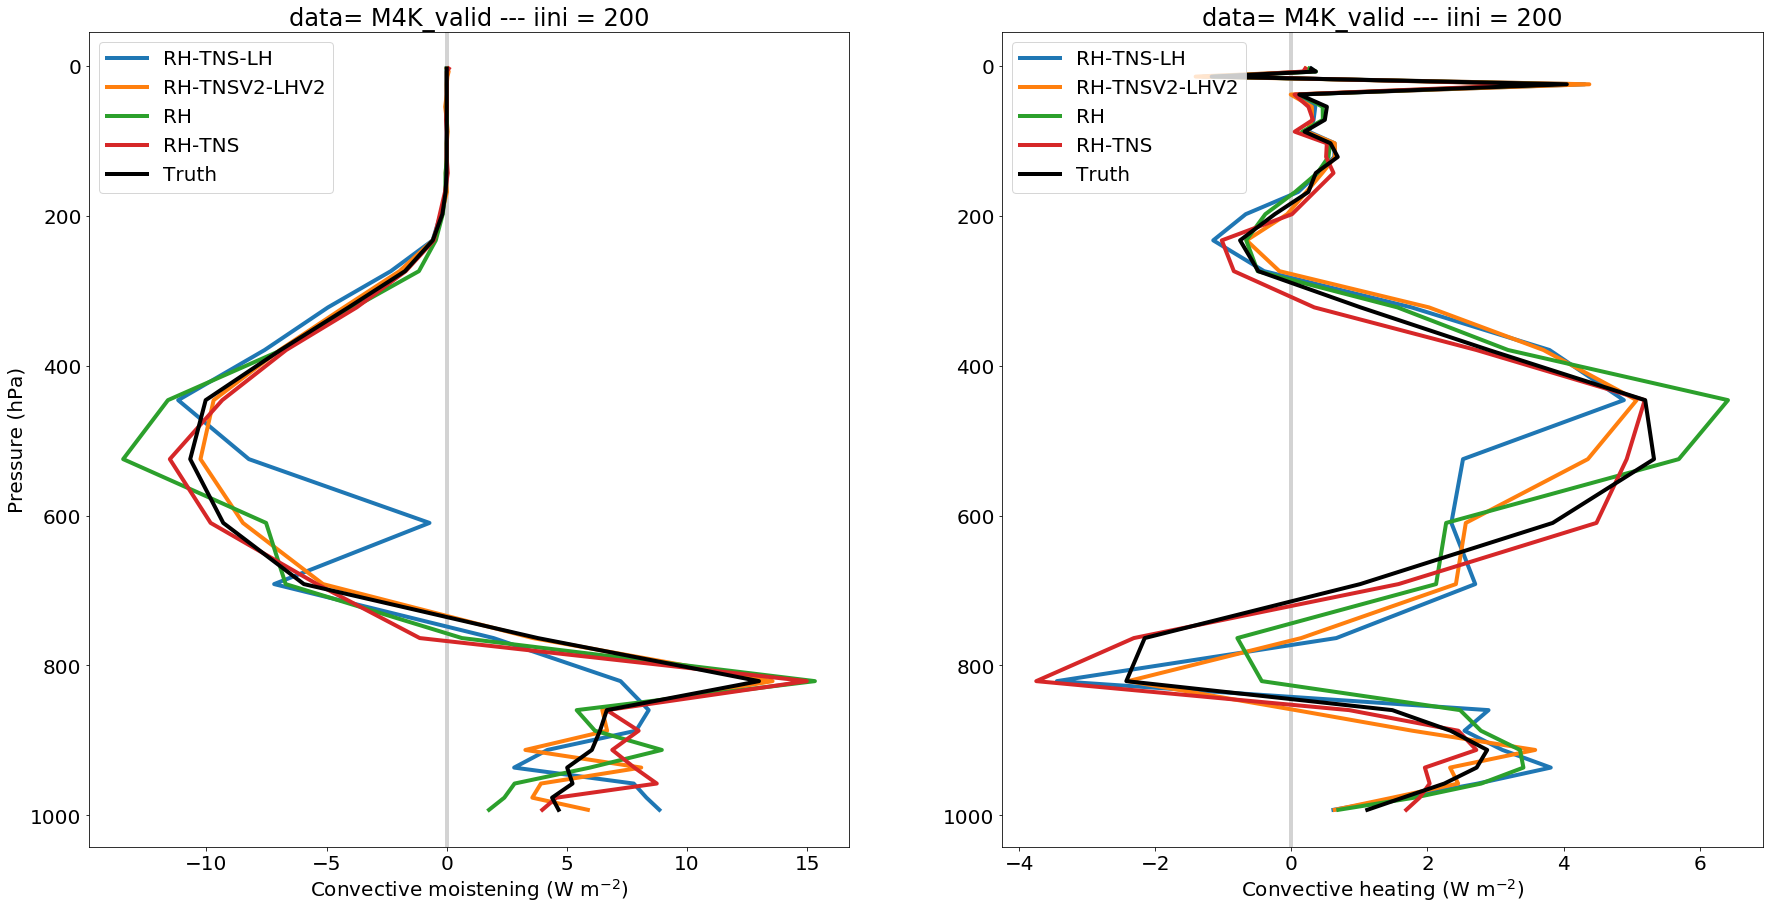

In [110]:


data = data_file[0][6:-3]
plt.figure(figsize=(30,15))
iini = iinis[0]
plt.subplot(1,2,1)
print(NNname)

plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.title('data= '+data+' '+ '--- iini = '+str(iini))


plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()


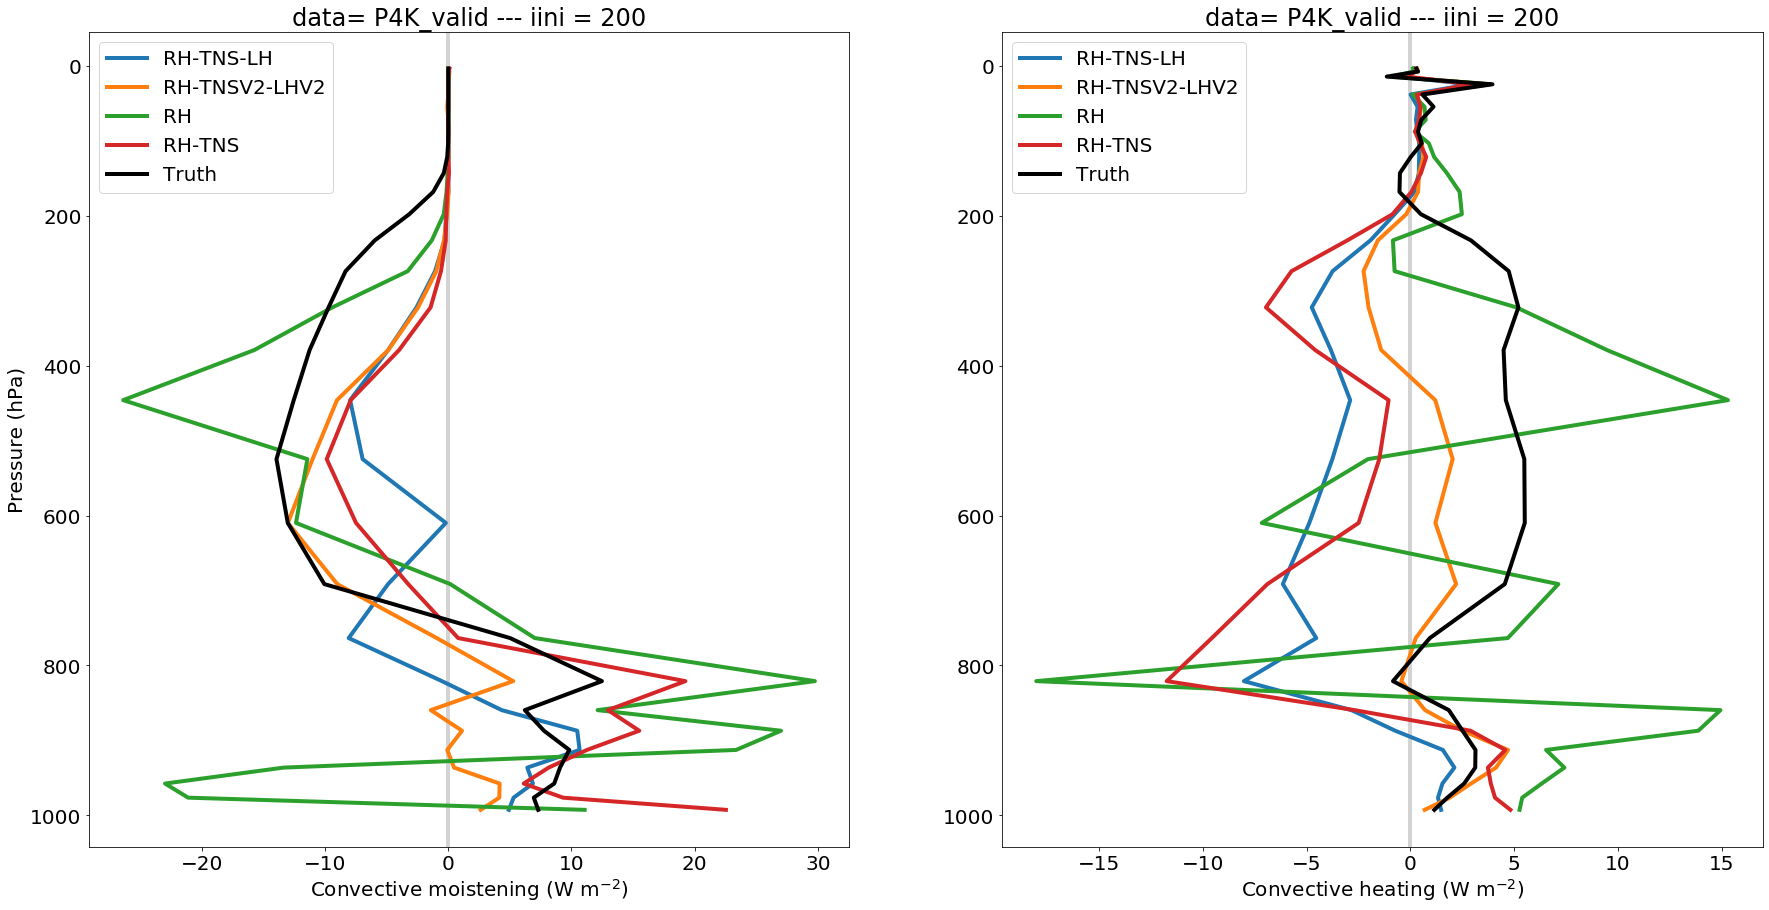

In [111]:


data = data_file[1][6:-3]
plt.figure(figsize=(30,15))
iini = iinis[0]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.title('data= '+data+' '+ '--- iini = '+str(iini))


plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()


## MSE

In [112]:
path_HDF5 = '/DFS-L/DATA/pritchard/ankitesg/models/' # Path to NN weights
config_file = 'CI_SP_M4K_CONFIG.yml' # Configuration file
data_file = ['CI_SP_M4K_valid.nc','CI_SP_P4K_valid.nc']  # Validation/test data sets
NNarray = ['BF.hdf5','CI01_RH_TNS_LHQsat.hdf5', 'RH_TNSV2_LHV2.hdf5','RH.hdf5', 'RH_TNS.hdf5'] # NN to evaluate 
NNname = ['BF','RH-TNS-LH','RH-TNSV2-LHV2','RH', 'RH-TNS'] # Name of NNs for plotting
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,
            'QV2RH':QV2RH,'T2TmTNS':T2TmTNS,'eliq':eliq,'eice':eice,'esat':esat,'qv':qv,'RH':RH,
           'reverseInterpLayer':reverseInterpLayer,'ScaleOp':ScaleOp}

In [114]:

#define default values


NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = path_HDF5+NNs
    
    rh_trans=False
    t2tns_trans=False
    lhflx_trans=False
    scaling=False
    interpolate=False
    model = path
    exp=None
    pos_model=None
    neg_model=None
    if 'RH' in NNs:
        rh_trans=True
    if 'TNS' in NNs:
        t2tns_trans=True
    if 'LH' in NNs:
        lhflx_trans=True
    if 'V2' in NNs:
        if "LHV2":
            exp = {"LHFLX":True}
        else:
            exp = {"LHFLX":False}
        
    if 'Scal' in NNs:
        pos,neg = NNs.split('*')
        pos_model = path_HDF5+pos
        neg_model = path_HDF5+neg
        model = None
        scaling=True
    if 'Interp' in NNs or 'Vert' in NNs:
        interpolate=True
        
    md[NNs] = {}
    for j,data in enumerate(data_file):
        print('data name is ',data)
        
        NN[NNs] = load_climate_model(dict_lay,'/export/nfs0home/ankitesg/CBrain_project/PrepData/'+config_file,
                                     '/DFS-L/DATA/pritchard/ankitesg/data/'+data,
                                     lev=lev,hyam=hyam,hybm=hybm,TRAINDIR='',
                                     inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
                                     inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
                                     rh_trans=rh_trans,t2tns_trans=t2tns_trans,
                                     lhflx_trans=lhflx_trans,scaling=scaling,interpolate=interpolate,
                                     model=model,exp=exp)
        
        md[NNs][data[6:-3]] = ModelDiagnostics(NN[NNs],
                                                '/export/nfs0home/ankitesg/CBrain_project/PrepData/'+config_file,
                                                '/DFS-L/DATA/pritchard/ankitesg/data/'+data)
        


[Errno 2] No such file or directory: '$TRAINDIR/HDF5_DATA'
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog
NN name is  BF.hdf5
data name is  CI_SP_M4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:931: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:931: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_P4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:931: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  CI01_RH_TNS_LHQsat.hdf5
data name is  CI_SP_M4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:931: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_P4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:931: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  RH_TNSV2_LHV2.hdf5
data name is  CI_SP_M4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:931: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_P4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:931: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  RH.hdf5
data name is  CI_SP_M4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:931: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_P4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:931: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  RH_TNS.hdf5
data name is  CI_SP_M4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/climate_invariant.py:931: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_P4K_valid.nc


/nfspool-0/home/ankitesg/CBRAIN-CAM/notebooks/ankitesh-devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [115]:
Nt = 30
data = data_file[0]
t_random = np.random.choice(np.linspace(0,md[NNs][data[6:-3]].valid_gen.n_batches-1,
                                        md[NNs][data[6:-3]].valid_gen.n_batches),
                            size=((Nt,)),replace=False).astype('int')

MSE = {}
VAR = {}
diagno = {}
diagno['truth'] = {}
diagno['pred'] = {}

for iar,itime in enumerate(t_random):
    print('iar=',iar,'/',Nt-1,' & itime',itime)
    for i,NNs in enumerate(NNarray):
        if iar==0: MSE[NNs] = {}; VAR[NNs] = {}
        for j,data in enumerate(data_file):
            #print('j=',j,'data=',data)

            inp, p, truth = md[NNs][data[6:-3]].get_inp_pred_truth(itime)  # [lat, lon, var, lev]

            t_geo = md[NNs][data[6:-3]].reshape_ngeo(truth)[:,:,:]
            if tf.is_tensor(p): p_geo = md[NNs][data[6:-3]].reshape_ngeo(p.numpy())[:,:,:]
            else: p_geo = md[NNs][data[6:-3]].reshape_ngeo(p)[:,:,:]

            if iar==0: 
                MSE[NNs][data[6:-3]] = np.mean((t_geo-p_geo)**2,axis=(1,2))
                VAR[NNs][data[6:-3]] = np.var(p_geo,axis=(1,2))
            else: 
                MSE[NNs][data[6:-3]] = np.concatenate((MSE[NNs][data[6:-3]],
                                                       np.mean((t_geo-p_geo)**2,axis=(1,2))),axis=0)
                VAR[NNs][data[6:-3]] = np.concatenate((VAR[NNs][data[6:-3]],
                                                       np.var(p_geo,axis=(1,2))),axis=0)

iar= 0 / 29  & itime 1086
iar= 1 / 29  & itime 778
iar= 2 / 29  & itime 1683
iar= 3 / 29  & itime 932
iar= 4 / 29  & itime 250
iar= 5 / 29  & itime 175
iar= 6 / 29  & itime 1266
iar= 7 / 29  & itime 1386
iar= 8 / 29  & itime 505
iar= 9 / 29  & itime 999
iar= 10 / 29  & itime 267
iar= 11 / 29  & itime 1658
iar= 12 / 29  & itime 1500
iar= 13 / 29  & itime 1241
iar= 14 / 29  & itime 1379
iar= 15 / 29  & itime 481
iar= 16 / 29  & itime 1119
iar= 17 / 29  & itime 698
iar= 18 / 29  & itime 1483
iar= 19 / 29  & itime 1555
iar= 20 / 29  & itime 879
iar= 21 / 29  & itime 187
iar= 22 / 29  & itime 1193
iar= 23 / 29  & itime 1507
iar= 24 / 29  & itime 911
iar= 25 / 29  & itime 1396
iar= 26 / 29  & itime 971
iar= 27 / 29  & itime 308
iar= 28 / 29  & itime 1521
iar= 29 / 29  & itime 1505


In [116]:
for i, name in enumerate(NNname):
    print(f"{name} MSE={np.sqrt(MSE[NNarray[i]]['M4K_valid'].mean())} STD={np.sqrt(MSE[NNarray[i]]['M4K_valid'].std())}")

BF MSE=18.696645736694336 STD=21.163063049316406
RH-TNS-LH MSE=18.6929874420166 STD=21.195261001586914
RH-TNSV2-LHV2 MSE=19.55785369873047 STD=22.13152503967285
RH MSE=18.53435707092285 STD=21.141332626342773
RH-TNS MSE=18.505334854125977 STD=21.03108787536621


In [117]:
for i, name in enumerate(NNname):
    print(f"{name} MSE={np.sqrt(MSE[NNarray[i]]['P4K_valid'].mean())} STD={np.sqrt(MSE[NNarray[i]]['P4K_valid'].std())}")

BF MSE=122.89603424072266 STD=195.80616760253906
RH-TNS-LH MSE=32.57390213012695 STD=40.019065856933594
RH-TNSV2-LHV2 MSE=31.94163703918457 STD=37.888084411621094
RH MSE=29.678234100341797 STD=35.16271209716797
RH-TNS MSE=31.997772216796875 STD=39.39573669433594


## idea classification 2

In [221]:
perc_path = '/export/nfs0home/ankitesg/data/percentile_data_bin_size_1000.pkl'
perc_array_m4k = load_pickle(perc_path)['Percentile']['M4K']
perc_array_p4k = load_pickle(perc_path)['Percentile']['P4K']
PERC_BINS = np.linspace(0,100,1001)

In [222]:
## Model RH.hdf5
md_name = 'RH.hdf5'
model = md[md_name]

In [223]:
model

{'M4K_valid': <cbrain.model_diagnostics.ModelDiagnostics at 0x7f694878c908>,
 'P4K_valid': <cbrain.model_diagnostics.ModelDiagnostics at 0x7f69482a5dd8>}

In [224]:
def convert_from_physical_to_percentile(p, PERC):
    ans = []
    var_dict = {"PHQ":PHQ_idx, "TPHYSTND":TPHYSTND_idx}
    for var in var_dict.keys():
        p_var = p[:,var_dict[var]]
        perc_var = PERC[var]
        lev_preds = []
        for ilev in range(30):
            lev_preds.append(np.interp(p_var[:,ilev],perc_var[ilev],PERC_BINS))
        p_percentile = np.stack(lev_preds, axis=1)
        ans.append(p_percentile)
    return np.concatenate(ans,axis=1)



In [225]:
def convert_from_percentile_to_physical(perc_val, PERC):
    ans = []
    var_dict = {"PHQ":PHQ_idx, "TPHYSTND":TPHYSTND_idx}
    for var in var_dict.keys():
        perc_var = perc_val[:,var_dict[var]]
        perc = PERC[var]
        lev_preds = []
        for ilev in range(30):
            lev_preds.append(np.interp(perc_var[:,ilev],PERC_BINS,perc[ilev]))
        p = np.stack(lev_preds, axis=1)
        ans.append(p)
        
    return np.concatenate(ans,axis=1)


In [226]:
lat_ind = np.arange(26,40)
iinis = 200
iend = iini+47

vals = {}
truth_vals = {}
for itime in tqdm(np.arange(iini,iend)):
    inp, p, truth = model['P4K_valid'].get_inp_pred_truth(itime)  
    p = p.numpy()
    percentil_space = convert_from_physical_to_percentile(p, perc_array_m4k)
    val = convert_from_percentile_to_physical(percentil_space,perc_array_p4k)
    if itime==iini:
        truth_vals['PHQ'] = model['P4K_valid'].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
        truth_vals['TPHYSTND'] = model['P4K_valid'].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
        vals['PHQ'] = model['P4K_valid'].reshape_ngeo(val[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
        vals['TPHYSTND'] = model['P4K_valid'].reshape_ngeo(val[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]

    else:
        
        vals['PHQ']  = np.concatenate((vals['PHQ'],
                                      model['P4K_valid'].\
                                     reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:,np.newaxis]),
                                    axis=3)
        vals['TPHYSTND']  = np.concatenate((vals['TPHYSTND'],
                                      model['P4K_valid'].\
                                     reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]),
                                    axis=3)
        
        truth_vals['PHQ'] = np.concatenate((truth_vals['PHQ'],
                                                     model['P4K_valid'].\
                                                     reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:,np.newaxis]),
                                                    axis=3)
        
        truth_vals['TPHYSTND'] = np.concatenate((truth_vals['TPHYSTND'],
                                             model['P4K_valid'].\
                                             reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]),
                                            axis=3)

/export/home/ankitesg/anaconda3/envs/CBrainEnv/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


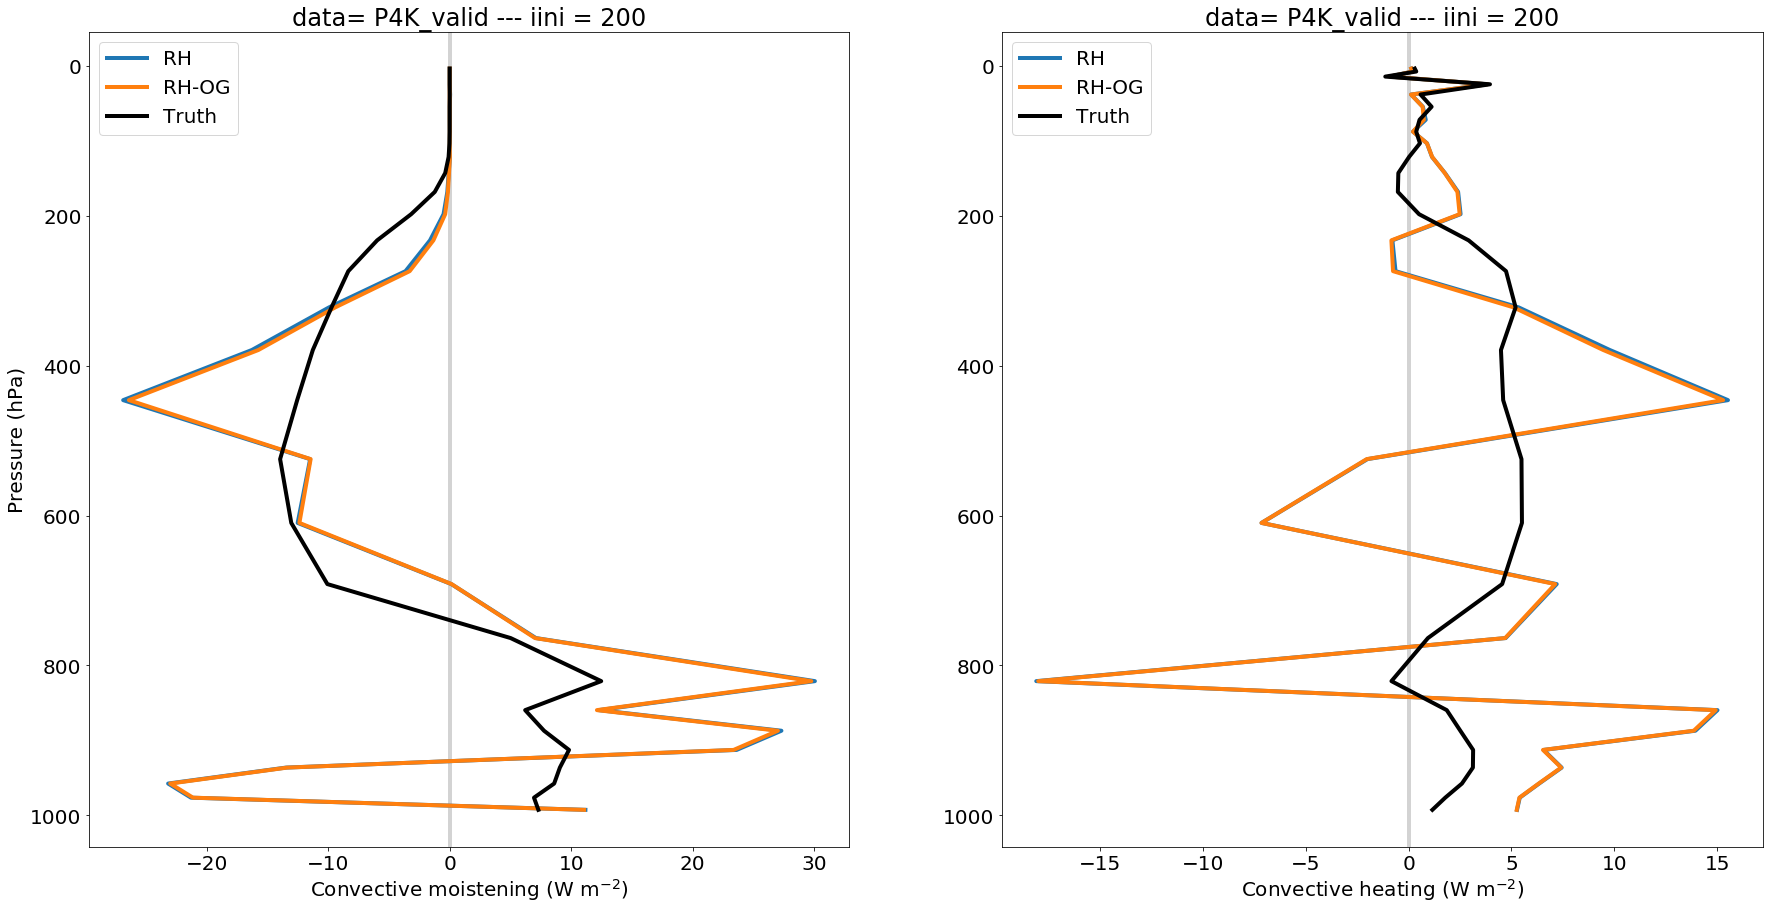

In [227]:
data = data_file[1][6:-3]
name = 'RH'
plt.figure(figsize=(30,15))
iini = 200
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
plt.plot(np.mean(vals['PHQ'],axis=(0,1,3)),lev,label=name)
plt.plot()
plt.plot(np.mean(diagno['RH.hdf5'][data][iini]['PHQ'],axis=(0,1,3)),lev,label=f'{name}-OG')
plt.plot(np.mean(truth_vals['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.title('data= '+data+' '+ '--- iini = '+str(iini))


plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
plt.plot(np.mean(vals['TPHYSTND'],axis=(0,1,3)),lev,label=name)
plt.plot(np.mean(diagno['RH.hdf5'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=f'{name}-OG')
plt.plot(np.mean(truth_vals['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()
